In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/train.csv")
meal_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/meal_info.csv")
fulfilment_center_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/fulfilment_center_info.csv")
test = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/test.csv")

merge1 = pd.merge(train, fulfilment_center_info, how='left')
merge2 = pd.merge(merge1, meal_info, how='left')

merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']] = merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']].astype('object')

df_weekly_orders = merge2.groupby(['week'])['num_orders'].sum().reset_index()
df_weekly_orders.set_index(df_weekly_orders['week'], inplace=True)
df_weekly_orders.drop(columns='week', inplace=True)

In [3]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

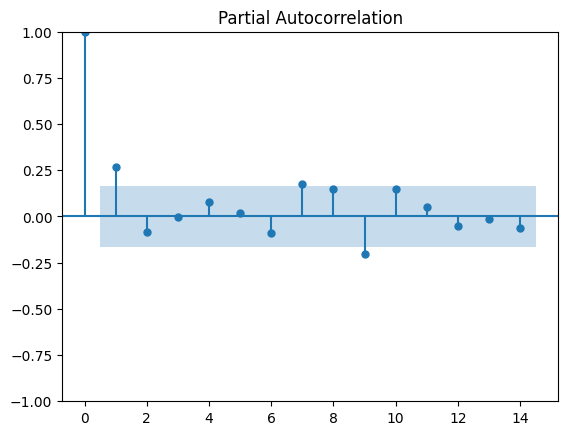

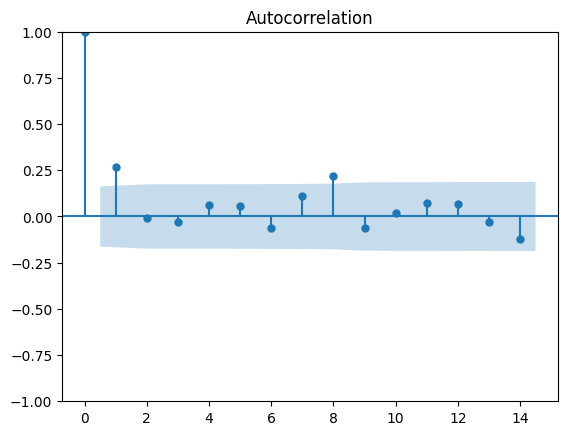

In [9]:
def plot_acf_pacf(y, lag):
    pacf = plot_pacf(y, lags=lag)
    acf = plot_acf(y, lags=lag)

plot_acf_pacf(df_weekly_orders['num_orders'], 14)

we can see that there is correlation of lag 1 in both, hence AR(1)& MA(1), but before this lets check if the Time Series is Stationary, Lets conduct Augmented Dickey-Fuller Test:

In [10]:
from statsmodels.tsa.stattools import adfuller

val_order_ = adfuller(df_weekly_orders['num_orders'], autolag='AIC')
print(f'T-stat: {val_order_[0]}')
print(f'P Value: {val_order_[1]}')
print(f'Lags: {val_order_[2]}')
print(f'Number of Observations used: {val_order_[3]}')
for key, val in val_order_[4].items():
    print(f'Critical Value at {key}: {val}\n')

if val_order_[1]>0.05:
    print('This Time Series Model is Non Stationary, may give bad predictions! :(\n')
else:
    print('This Time Series Model is Stationary, getting prediction is recommended! :)\n')

T-stat: -2.542865772667445
P Value: 0.1053898340403121
Lags: 9
Number of Observations used: 135
Critical Value at 1%: -3.479742586699182

Critical Value at 5%: -2.88319822181578

Critical Value at 10%: -2.578319684499314

This Time Series Model is Non Stationary, may give bad predictions! :(



In [11]:
'''We need to convert This NON STATIONARY TS into STATIONARY TS using FIRST ORDER DIFFERENCING'''

df_weekly_orders.head()

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675


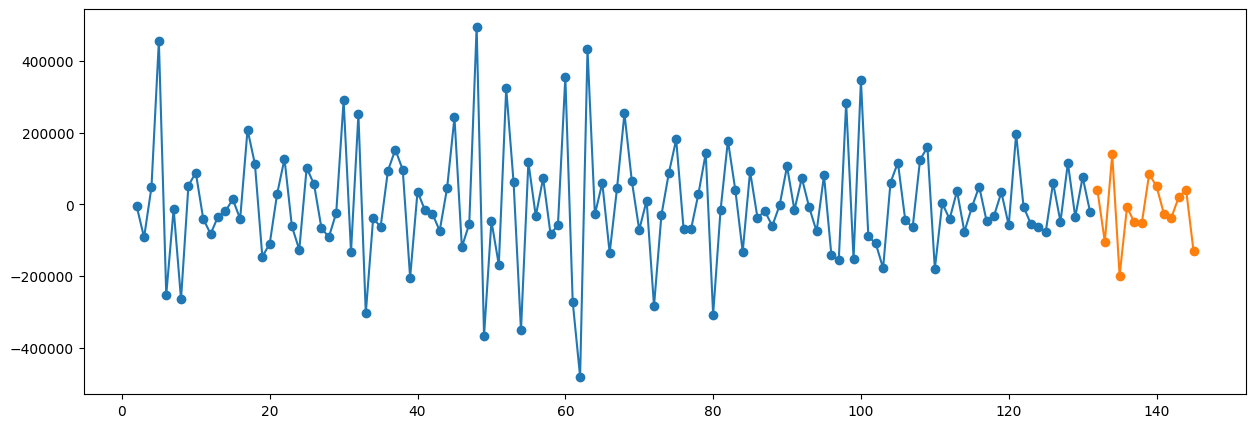

In [34]:
orders_diff = df_weekly_orders['num_orders'].diff().dropna() #we can add params like periods=1, axis=0 (rows default)
train_orders = orders_diff[:130]
val_orders = orders_diff[130:]

plt.figure(figsize=(15,5))
# plt.plot(df_weekly_orders['num_orders'], marker='o')
plt.plot(train_orders, marker='o')
plt.plot(val_orders, marker='o')

plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller

val_order_ = adfuller(train_orders, autolag='AIC')
print(f'T-stat: {val_order_[0]}')
print(f'P Value: {val_order_[1]}')
print(f'Lags: {val_order_[2]}')
print(f'Number of Observations used: {val_order_[3]}')
for key, val in val_order_[4].items():
    print(f'Critical Value at {key}: {val}\n')

if val_order_[1]>0.05:
    print('This Time Series Model is Non Stationary, may give bad predictions! :(\n')
else:
    print('This Time Series Model is Stationary, getting prediction is recommended! :)\n')

T-stat: -6.3375558591662315
P Value: 2.806264467185515e-08
Lags: 8
Number of Observations used: 121
Critical Value at 1%: -3.485585145896754

Critical Value at 5%: -2.885738566292665

Critical Value at 10%: -2.5796759080663887

This Time Series Model is Stationary, getting prediction is recommended! :)



A simple First order differencing gave us P-value << 0.05, Hence we will move forward with our ARIMA Modelling, <br>

Now, let's check (p) & (q) value by ACF & PACF

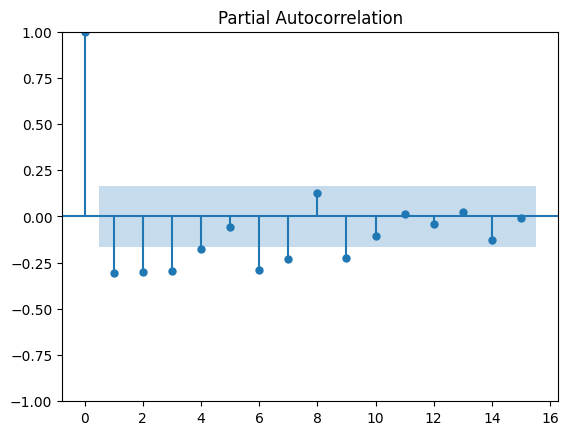

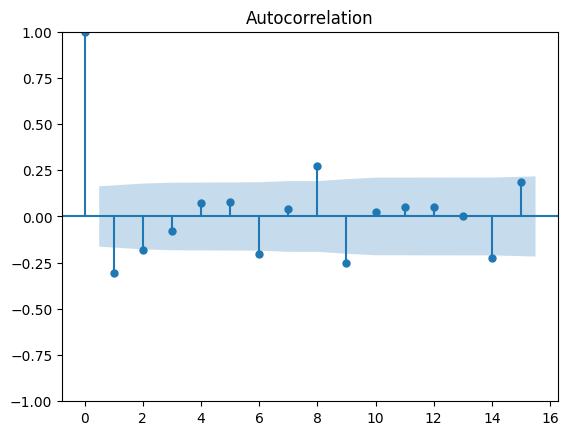

In [36]:
plot_acf_pacf(orders_diff, 15)

By these 2 graphs, we know that, ACF -> q = 2 -> MA(2) | PACF -> p = 4 -> AR(4)<br>
Hence, $ARMA(4,2)$

In [40]:
model = ARIMA(train_orders, order=(4,0,2), seasonal_order=(0,0,0,0))
model_fit = model.fit()
# model.summary()

In [41]:
pred =  model_fit.forecast(14)

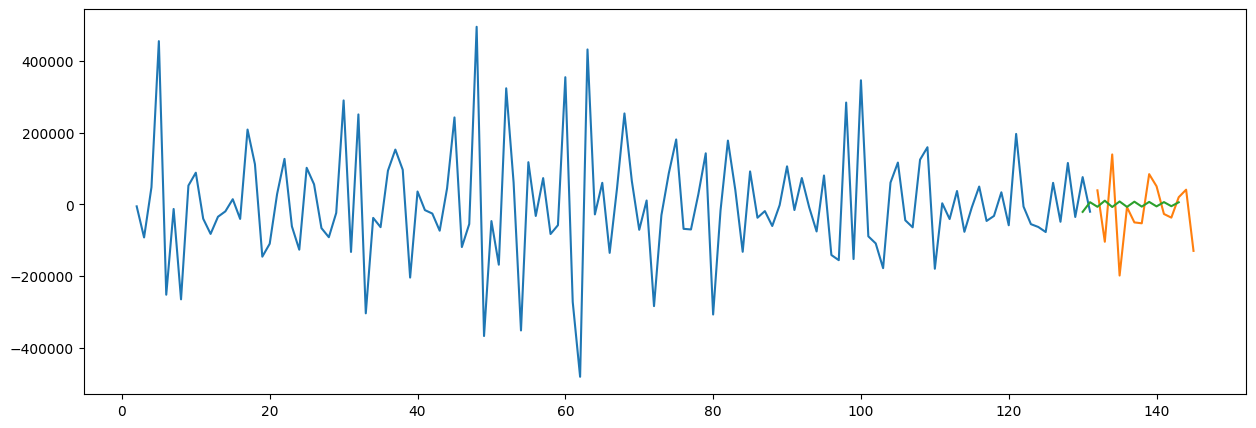

In [42]:
plt.figure(figsize=(15,5))
plt.plot(train_orders)
plt.plot(val_orders)
plt.plot(pred)
plt.show()

#### Undo-Transformation to original data

In [52]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [61]:
orders_diff

week
2       -5177.0
3      -91822.0
4       48267.0
5      455146.0
6     -251387.0
         ...   
141    -26449.0
142    -36579.0
143     20265.0
144     41271.0
145   -129271.0
Name: num_orders, Length: 144, dtype: float64

In [83]:
[initial][0]

num_orders    792261
Name: 1, dtype: int64

In [51]:
df_weekly_orders['num_orders'][0:1][1]

np.int64(792261)

In [ ]:
def undo_transformation():
    